# Project: Stock Price Prediction

In [79]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

### Overall Goal

Predict stock price (high) on day X+1 as precisely as possible.

### Data Import And Cleaning

In [20]:
#get data

path_to_df = "..\Data\SPX.csv"
df = pd.read_csv(path_to_df)

df = df[::-1].reset_index(drop=True) #reverse order

df.head()

,Date,Close/Last,Open,High,Low
0,02/24/2014,1847.61,1836.78,1858.71,1836.78
1,02/25/2014,1845.12,1847.66,1852.91,1840.19
2,02/26/2014,1845.16,1845.79,1852.65,1840.66
3,02/27/2014,1854.29,1844.90,1854.53,1841.13
4,02/28/2014,1859.45,1855.12,1867.92,1847.67


In [21]:
def plot_chart(df, col): # Plotting the col against dates
    # Create a larger plot
    fig, ax = plt.subplots(figsize=(12, 6))
    num_args = len(col)

    for ind in range(num_args):
        ax.plot(df['Date'], df[col[ind]])

    ax.set_title('Plot of price over time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Automatically set the x-axis date labels based on available space
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout for better appearance
    plt.show() 

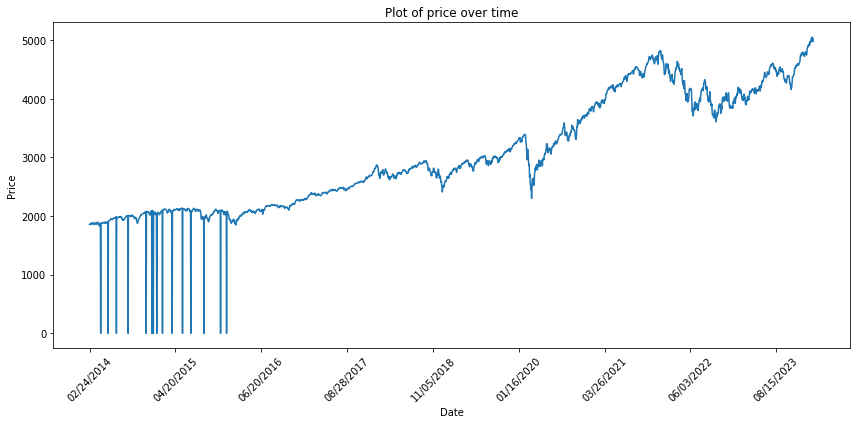

In [22]:
plot_chart(df, ["High"])

In [33]:
#remove data before june 2016
df['Date'] = pd.to_datetime(df['Date'])
df_filtered = df[df['Date'] >= '06/01/2016']
df_filtered = df_filtered.reset_index(drop=True)

df_filtered.head()

,Date,Close/Last,Open,High,Low
0,2016-06-01,2099.33,2093.94,2100.97,2085.10
1,2016-06-02,2105.26,2097.71,2105.26,2088.59
2,2016-06-03,2099.13,2104.07,2104.07,2085.36
3,2016-06-06,2109.41,2100.83,2113.36,2100.83
4,2016-06-07,2112.13,2110.18,2119.22,2110.18


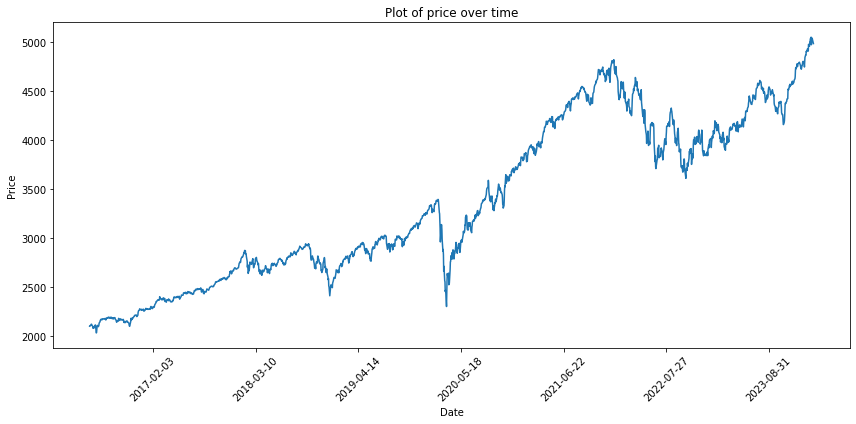

In [34]:
plot_chart(df_filtered, ["High"])

### 1. Linear Regression

In [25]:
#Technique 1: Linear Regression
#fit model to the last X (Hyperparam) days
#use model to predict price on day X+1
#eval

In [35]:
#fit model

def fit_lin_reg(X):
    model = LinearRegression()

    stock_prices = df_filtered["High"].values
    predicted_stock_prices = [0] * X

    for ind, _ in enumerate(stock_prices): #loop over daily highs
        if ind >= len(stock_prices) - X:
            break
        prices = stock_prices[ind:ind + X] #get X highs (label)
        days = np.arange(X).reshape(-1, 1) #X days (feature)
        model.fit(days, prices) #fit model to training examples
        y_pred = model.predict(np.array(X + 1).reshape(-1, 1)) #predict on day X+1
        predicted_stock_prices.append(round(y_pred[0], 2)) 

    predicted_stock_prices = np.array(predicted_stock_prices)
    df_filtered_ext = df_filtered.copy()
    df_filtered_ext["lin_reg_pred"] = predicted_stock_prices
    return df_filtered_ext

df_filtered_ext = fit_lin_reg(5)

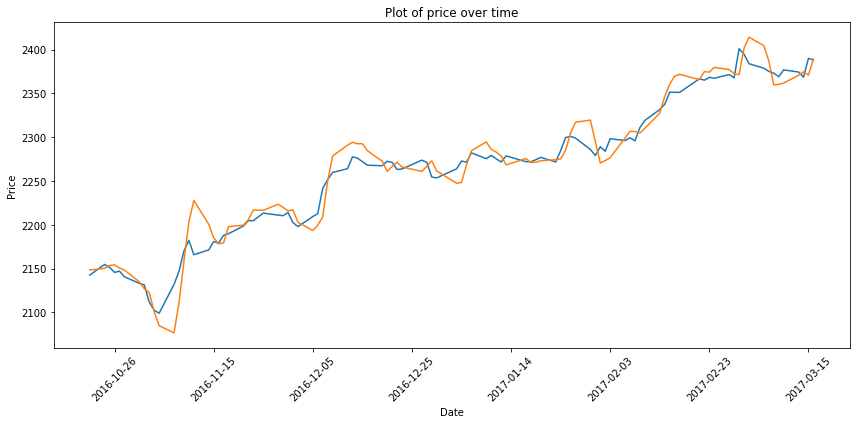

In [36]:
#plot
plot_chart(df_filtered_ext[100:200], ["High", "lin_reg_pred"])

In [37]:
#eval

#print(df_filtered_ext["High"][X:])
#print(df_filtered_ext["lin_reg_pred"][X:])
errors = []

for X in tqdm(range(1,20)):
    df_filtered_ext = fit_lin_reg(X)
    mse = np.mean((df_filtered_ext["High"][X:] - df_filtered_ext["lin_reg_pred"][X:]) ** 2)
    errors.append(mse)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


Lowest MSE is 960.7744060730826, with X=1 (just copies high from prev day)
Lowest MSE is 2472.6941750258, with non-trivial X=5


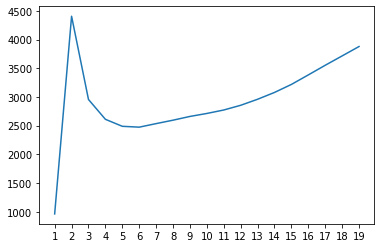

In [38]:
x_values = np.arange(1, len(errors) + 1)
plt.plot(x_values, errors)
plt.xticks(np.arange(1, len(errors) + 1, 1))

best_X, best_MSE = min(enumerate(errors), key=lambda x: x[1])
print(f"Lowest MSE is {best_MSE}, with X={best_X+1} (just copies high from prev day)")

errors_copy = errors.copy()

del errors_copy[best_X]

sec_best_X, sec_best_MSE = min(enumerate(errors_copy), key=lambda x: x[1])
print(f"Lowest MSE is {sec_best_MSE}, with non-trivial X={sec_best_X+1}")

Can I find a method that is better than just copying the value from the previous day?

### 2. Multilayer Perceptron

In [39]:
print(df_filtered_ext.head)

<bound method NDFrame.head of            Date  Close/Last     Open     High      Low  lin_reg_pred
0    2016-06-01     2099.33  2093.94  2100.97  2085.10          0.00
1    2016-06-02     2105.26  2097.71  2105.26  2088.59          0.00
2    2016-06-03     2099.13  2104.07  2104.07  2085.36          0.00
3    2016-06-06     2109.41  2100.83  2113.36  2100.83          0.00
4    2016-06-07     2112.13  2110.18  2119.22  2110.18          0.00
...         ...         ...      ...      ...      ...           ...
1939 2024-02-14     5000.62  4976.44  5002.52  4956.45       5050.36
1940 2024-02-15     5029.73  5003.14  5032.72  4999.44       5046.23
1941 2024-02-16     5005.57  5031.13  5038.70  4999.52       5052.65
1942 2024-02-20     4975.51  4989.32  4993.71  4955.02       5060.44
1943 2024-02-21     4981.80  4963.03  4983.21  4946.00       5054.50

[1944 rows x 6 columns]>


In [91]:
# prepare training data

FEATURE_VEC_LEN = 3

features = []
labels = []
df_len = len(df_filtered_ext.values)


for ind in range(df_len):
    feature_vec = []
    if ind < df_len - FEATURE_VEC_LEN:
        for ind2 in range(FEATURE_VEC_LEN):
            feature = df_filtered_ext.loc[ind + ind2]["High"]
            feature_vec.append(feature)

        label = df_filtered_ext.loc[ind + ind2 + 1]["High"]
        labels.append(label)
        features.append(feature_vec)

features = np.array(features)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=False)

# Shuffle only the training set
shuffle_indices = np.arange(len(X_train))
np.random.shuffle(shuffle_indices)

X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
# init model

model = Sequential()
model.add(Dense(units=8, input_dim=FEATURE_VEC_LEN, activation='relu'))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

In [53]:
# training

history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
1552/1552 [==============================] - 5s 2ms/step - loss: 11766676.0000
Epoch 2/100
1552/1552 [==============================] - 3s 2ms/step - loss: 8536284.0000
Epoch 3/100
1552/1552 [==============================] - 3s 2ms/step - loss: 3177073.5000
Epoch 4/100
1552/1552 [==============================] - 3s 2ms/step - loss: 982611.3125
Epoch 5/100
1552/1552 [==============================] - 3s 2ms/step - loss: 742207.8125
Epoch 6/100
1552/1552 [==============================] - 3s 2ms/step - loss: 590421.6250
Epoch 7/100
1552/1552 [==============================] - 3s 2ms/step - loss: 418508.7500
Epoch 8/100
1552/1552 [==============================] - 3s 2ms/step - loss: 248763.4062
Epoch 9/100
1552/1552 [==============================] - 3s 2ms/step - loss: 130340.0312
Epoch 10/100
1552/1552 [==============================] - 3s 2ms/step - loss: 64177.5352
Epoch 11/100
1552/1552 [==============================] - 3s 2ms/step - loss: 29758.6445
Epoch 12/100
1552

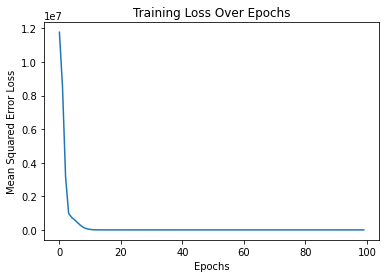

In [55]:
# training loss plotting
training_loss = history.history["loss"]
plt.plot(training_loss)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.show()

In [92]:
# eval

y_pred = model.predict(X_test)

print(X_test[:10])
print(y_pred[:10])
print(y_test[:10])

mse = mean_squared_error(y_test, y_pred)

print(mse)

13/13 [==============================] - 0s 2ms/step
[[1.31245303 1.30489689 1.3390591 ]
 [1.30655379 1.34070267 1.3306701 ]
 [1.34235745 1.33231419 1.31788246]
 [1.33396946 1.31952735 1.36402857]
 [1.32118338 1.36567059 1.29907634]
 [1.36732389 1.3007224  1.39617544]
 [1.30237955 1.39781547 1.4579143 ]
 [1.39946686 1.45955048 1.48762481]
 [1.46119822 1.48925914 1.51570229]
 [1.49090512 1.51733488 1.54663757]]
[[4474.2847]
 [4469.4233]
 [4457.998 ]
 [4494.429 ]
 [4445.0503]
 [4518.445 ]
 [4573.8433]
 [4598.2935]
 [4620.721 ]
 [4646.083 ]]
[4161.29 4151.58 4186.62 4137.3  4211.03 4257.91 4280.47 4301.79 4325.28
 4302.18]
111312.07531606728


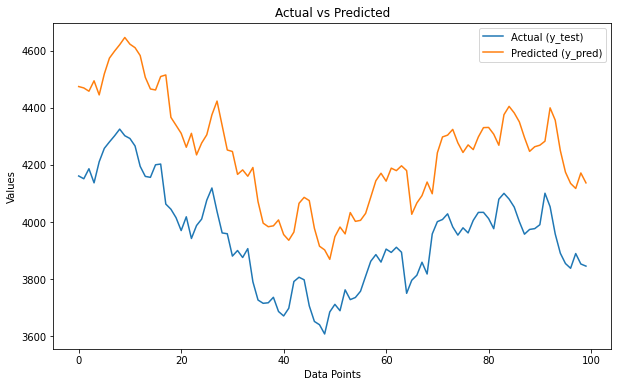

In [93]:
# Plot y_test and y_pred with a larger chart size
plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.plot(y_test, label='Actual (y_test)')
plt.plot(y_pred, label='Predicted (y_pred)')
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.show()